In [1]:
%matplotlib inline
from sklearn import linear_model
import scipy.stats
import os
import shutil
import re
import numpy as np
import pandas as pd
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
from Bio import SeqIO
from src import contig_stats
sns.set_style("whitegrid")

In [2]:
path = "/media/NGS/Sequence/Clostridium_perfringens/NCBI"

In [3]:
def run(args):
    fasta, file = args
    id = re.sub(r".fna$", "", file)
    n25, n50, n75, m, c = contig_stats.stats(list(SeqIO.parse(fasta, "fasta")))
    return id, n25, n50, n75, m, c

In [4]:
args = ((os.path.join(path, file), file) for file in os.listdir(path))
data = list(ProcessPoolExecutor(25).map(run, args))

In [23]:
table = pd.DataFrame(data, columns=["id", "N25", "N50", "N75", "total_length", "counts"])
table.head()

,id,N25,N50,N75,total_length,counts
0,GCA_003245405.1,3502074,3502074,3502074,3738529,31
1,GCA_003181705.1,1428744,242799,146679,3725979,128
2,GCA_003475625.1,257314,132910,62953,3402500,49
3,GCA_001949305.1,237044,143793,70034,3580610,59
4,GCA_902166025.1,1861412,1861412,248908,3330548,19


In [24]:
identify = pd.read_csv('/media/NGS/Sequence/Clostridium_perfringens/Identify.csv', index_col=0)
identify = identify[(identify['Species'] == 'Clostridium perfringens')]

table = pd.merge(table, identify, left_on='id', right_index=True)
table.shape

(153, 9)

# N25, N50, N75

Text(0, 0.5, 'number')

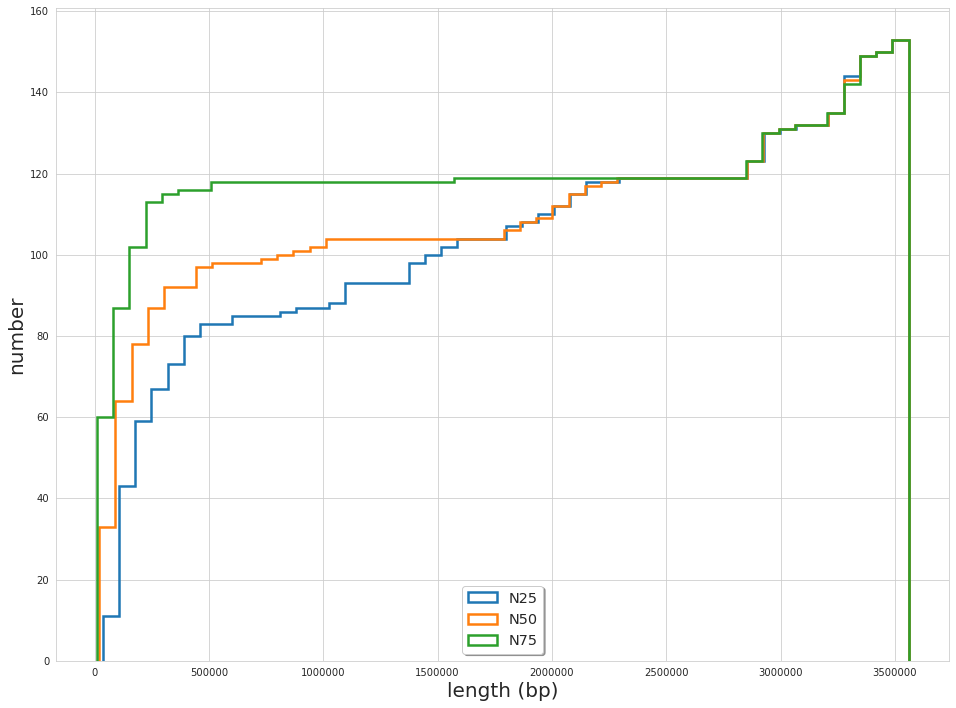

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.hist(table["N25"], bins=50, histtype="step", cumulative=True, lw=2.5, label="N25")
ax.hist(table["N50"], bins=50, histtype="step", cumulative=True, lw=2.5, label="N50")
ax.hist(table["N75"], bins=50, histtype="step", cumulative=True, lw=2.5, label="N75")
ax.legend(loc='lower center', shadow=True, fontsize='x-large')
plt.xlabel("length (bp)", fontsize=20)
plt.ylabel("number", fontsize=20)

Text(0, 0.5, 'number')

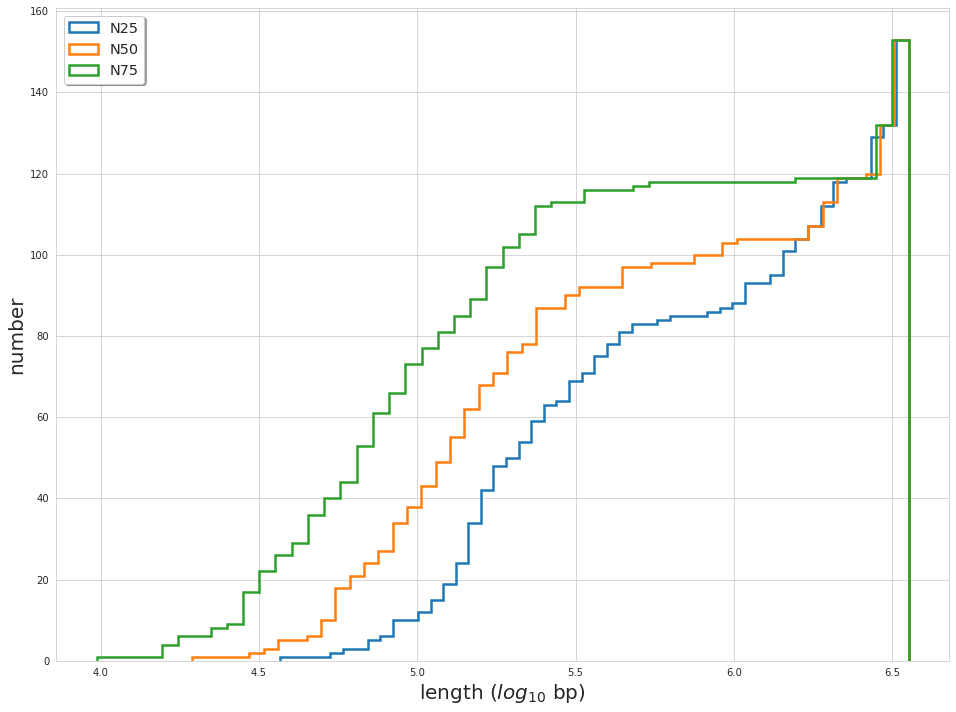

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.hist(np.log10(table["N25"]), bins=50, histtype="step", cumulative=True, lw=2.5, label="N25")
ax.hist(np.log10(table["N50"]), bins=50, histtype="step", cumulative=True, lw=2.5, label="N50")
ax.hist(np.log10(table["N75"]), bins=50, histtype="step", cumulative=True, lw=2.5, label="N75")
ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xlabel("length ($log_{10}$ bp)", fontsize=20)
plt.ylabel("number", fontsize=20)

In [25]:
curated = table[(table['N50'] >= 10 ** 5.3)]
curated.shape

(81, 9)

# Combine metadata selection

In [14]:
metafile = "/media/NGS/Sequence/Clostridium_perfringens/METADATA.csv"
meta = pd.read_csv(metafile)
meta = meta[meta["GC%"] != "-"]
meta["GC%"] = meta['GC%'].astype(float)

/home/chen1i6c04/.conda/envs/Notebook/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [21]:
meta['Assembly'] = meta['Assembly'].str.rstrip()

In [26]:
curated = pd.merge(curated, meta, left_on='id', right_on="Assembly")

In [24]:
def fence(df, subset):
    q1, q2, q3 = scipy.stats.mstats.mquantiles(df[subset])
    iqr = q3 - q1
    lowest = q1-1.5*iqr
    highest = q3+1.5*iqr
    return (curated[subset]>=lowest)&(curated[subset]<=highest)

In [16]:
def fence(df, subset):
    std = curated[subset].std()
    mean = curated[subset].mean()
    return (curated[subset]>(mean - 2*std))&(curated[subset]<(mean + 2*std))

In [27]:
curated['outlier'] = ~(fence(curated, 'Size (Mb)')&fence(curated, 'GC%'))
curated[~curated['outlier']].shape

(76, 29)

/home/chen1i6c04/.conda/envs/Notebook/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


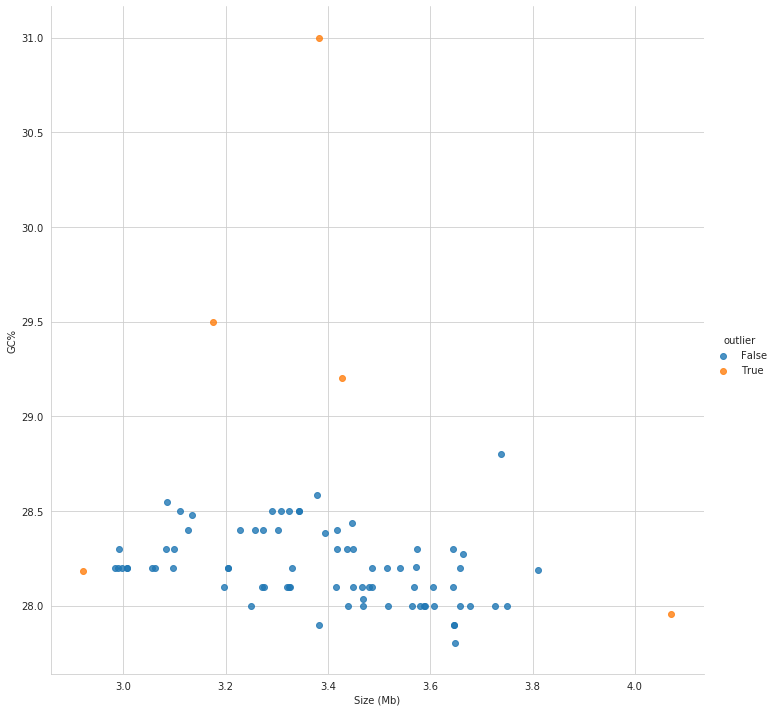

In [28]:
sns.lmplot(data=curated, x="Size (Mb)", y="GC%", fit_reg=False, size=10, hue='outlier')

# Counts

Text(0.5, 1.0, 'Genome contig number distribution')

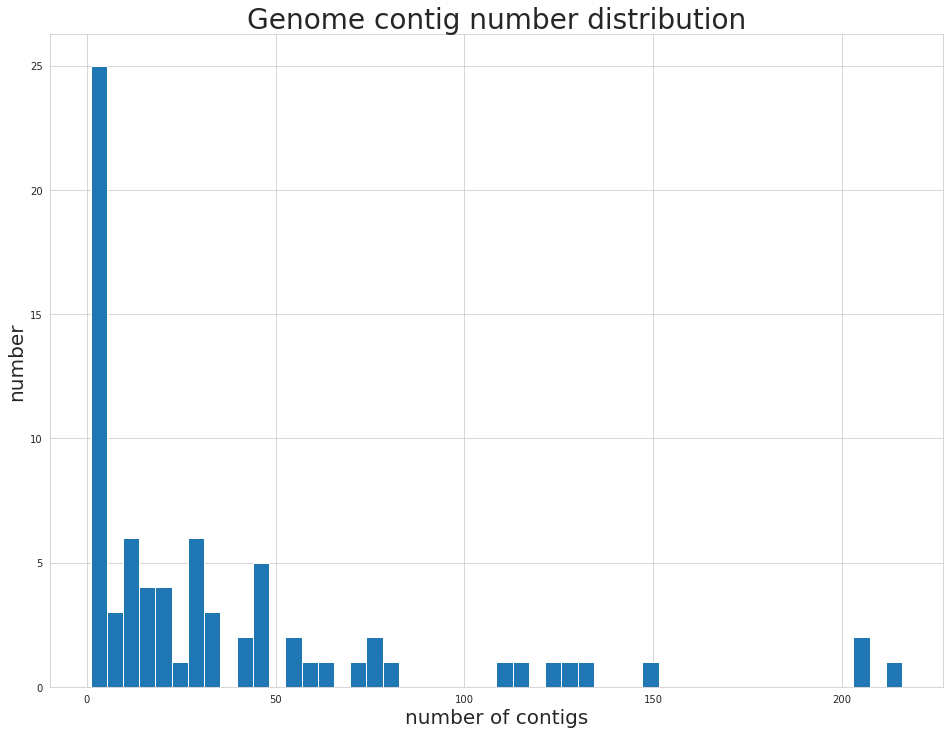

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.hist(curated["counts"][~curated['outlier']], bins=50)
plt.xlabel("number of contigs", fontsize=20)
plt.ylabel("number", fontsize=20)
plt.title("Genome contig number distribution", fontsize=28)

In [30]:
for i in curated['id'][~curated['outlier']]:
    shutil.copy(os.path.join(path, i+'.fna'), '/media/NGS/Sequence/Clostridium_perfringens/NCBI_clean')